# Задача 3. Многоклассовая классификация и множественная классификация/регрессия

Паршин Максим Алексеевич, 22.М07-мм

- Изучите возможности sklearn для решения задач Multiclass classification, Multilabel classification и Multioutput Regression. Основные компоненты библиотеки указаны на рисунке ниже. multi_org_chart

- Найдите данные, на которых можно решить задачу Multiclass classification (классификация с более чем двумя классами). В крайнем случае преобразуйте данные, предназначенные для другой задачи.

- Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи.

- При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).

- Используя стратегии OneVsRest, OneVsOne и OutputCode решите задачу Multiclass classification для каждого из пройденных базового алгоритма классификации (logistic regression, svm, knn, naive bayes, decision tree). При обучении использовать подбор гиперпараметров, кросс-валидацию и при необходимости масштабирование данных, добиться наилучшего качества предсказания.

- Замерить время обучения каждой модели для каждой стратегии.

- Для оценки качества моделей используйте метрику AUC-ROC.

- Сравнить время обучения и качество всех моделей и всех стратегий. Сделать выводы.

- (+3 балла) Повторить все пункты для задачи Multilabel classification (классификация с несколькими целевыми признаками, например, бинарными). В качестве стратегий попробовать MultiOutputClassifier и ClassifierChain.

 ❌  (+2 балла) Повторить все пункты для задачи Multioutput Regression (регрессия с несколькими целевыми признаками, вещественными). Модель попробовать как минимум одну: Ridge. В качестве стратегий попробовать MultiOutputRegressor и RegressorChain. В качестве метрики использовать R2.

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import copy
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier, OutputCodeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
import time


warnings.filterwarnings('ignore')

# 1. Multiclass classification

Датасет: https://www.kaggle.com/datasets/kukuroo3/body-performance-data (показатели по результатам физических упражнений в зависимости от пола и возраста, целевой признак -- класс подготовки)

In [133]:
data = pd.read_csv('body.csv').sample(1000)

In [134]:
data.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
9567,62.0,M,178.8,78.5,19.6,95.0,147.0,44.7,15.1,32.0,186.0,A
11105,24.0,M,173.9,58.4,16.5,77.0,122.0,31.2,12.8,38.0,210.0,D
7026,27.0,M,172.1,73.2,21.9,86.0,158.0,48.7,18.5,51.0,234.0,A
8057,40.0,F,167.0,54.3,20.0,60.0,122.0,26.7,19.5,37.0,157.0,A
290,27.0,F,164.6,56.9,29.4,68.0,148.0,26.8,19.9,51.0,183.0,A


In [135]:
data.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

In [136]:
data['class'].replace(['A', 'B', 'C', 'D'], [1, 2, 3, 4], inplace=True)

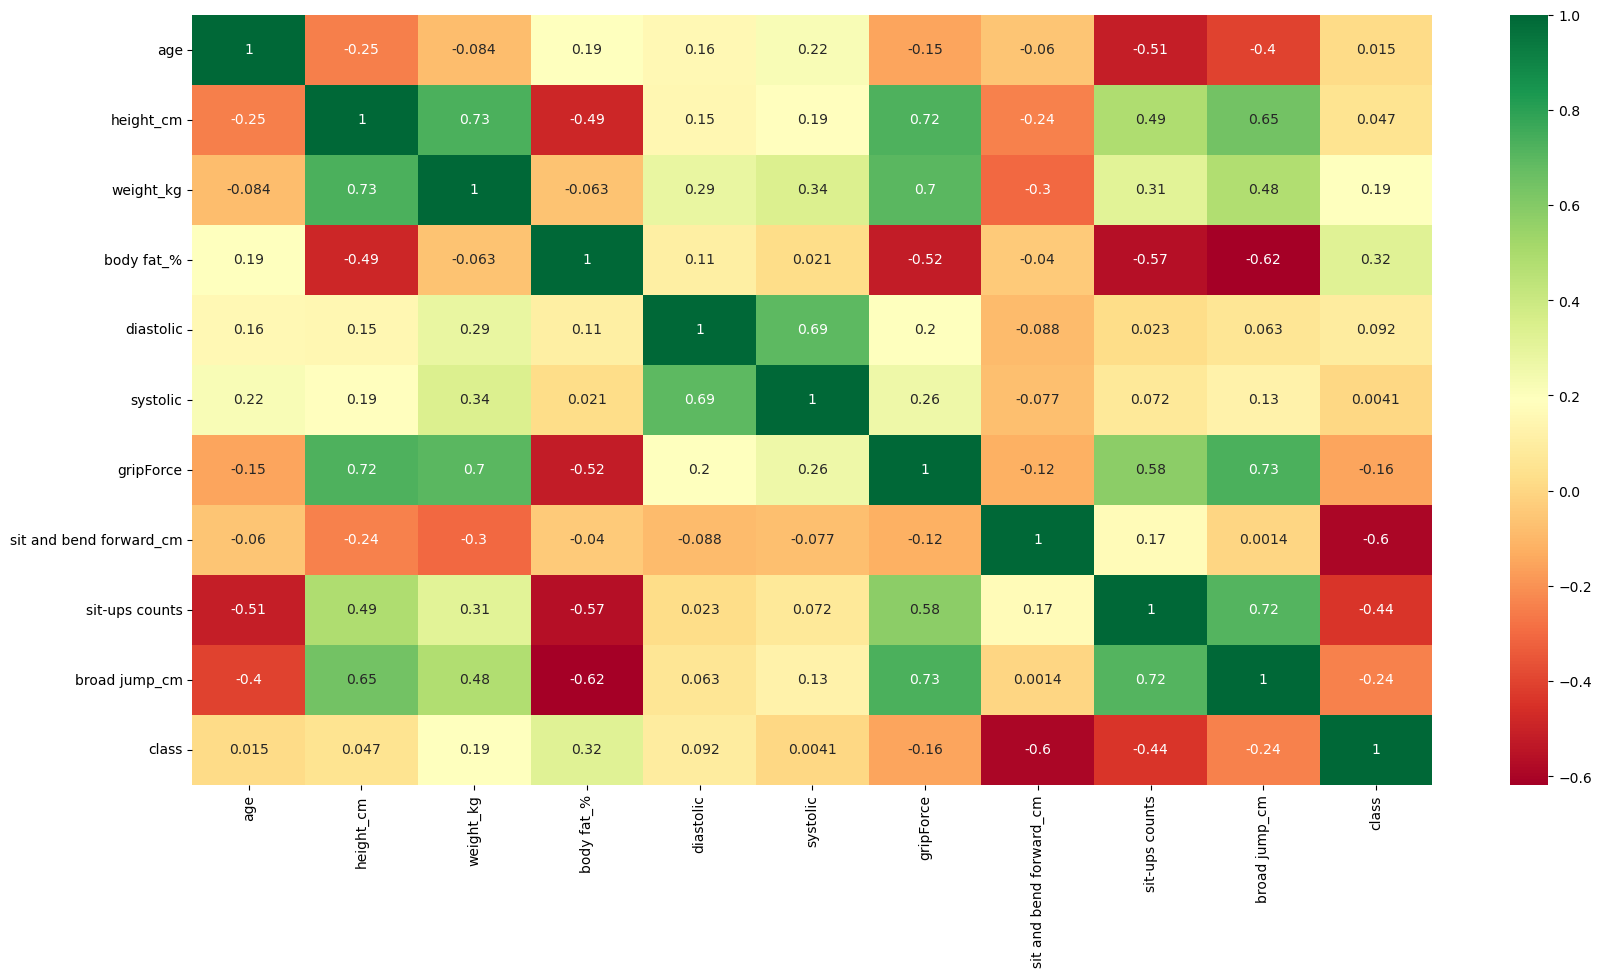

In [137]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Преобразуем признак пола в количественный

In [138]:
data['gender'] = data['gender'].map(lambda g: 1 if g == 'M' else 0)

Рост и вес сами по себе вряд ли говорят что-то о возможном уровне физической подготовки (что видно и по корреляции), поэтому рассмотрим индекс массы тела: 

In [139]:
data['index'] = data['weight_kg'] / (data['height_cm'] / 100)**2
data.drop(['weight_kg', 'height_cm'], axis=1, inplace = True)

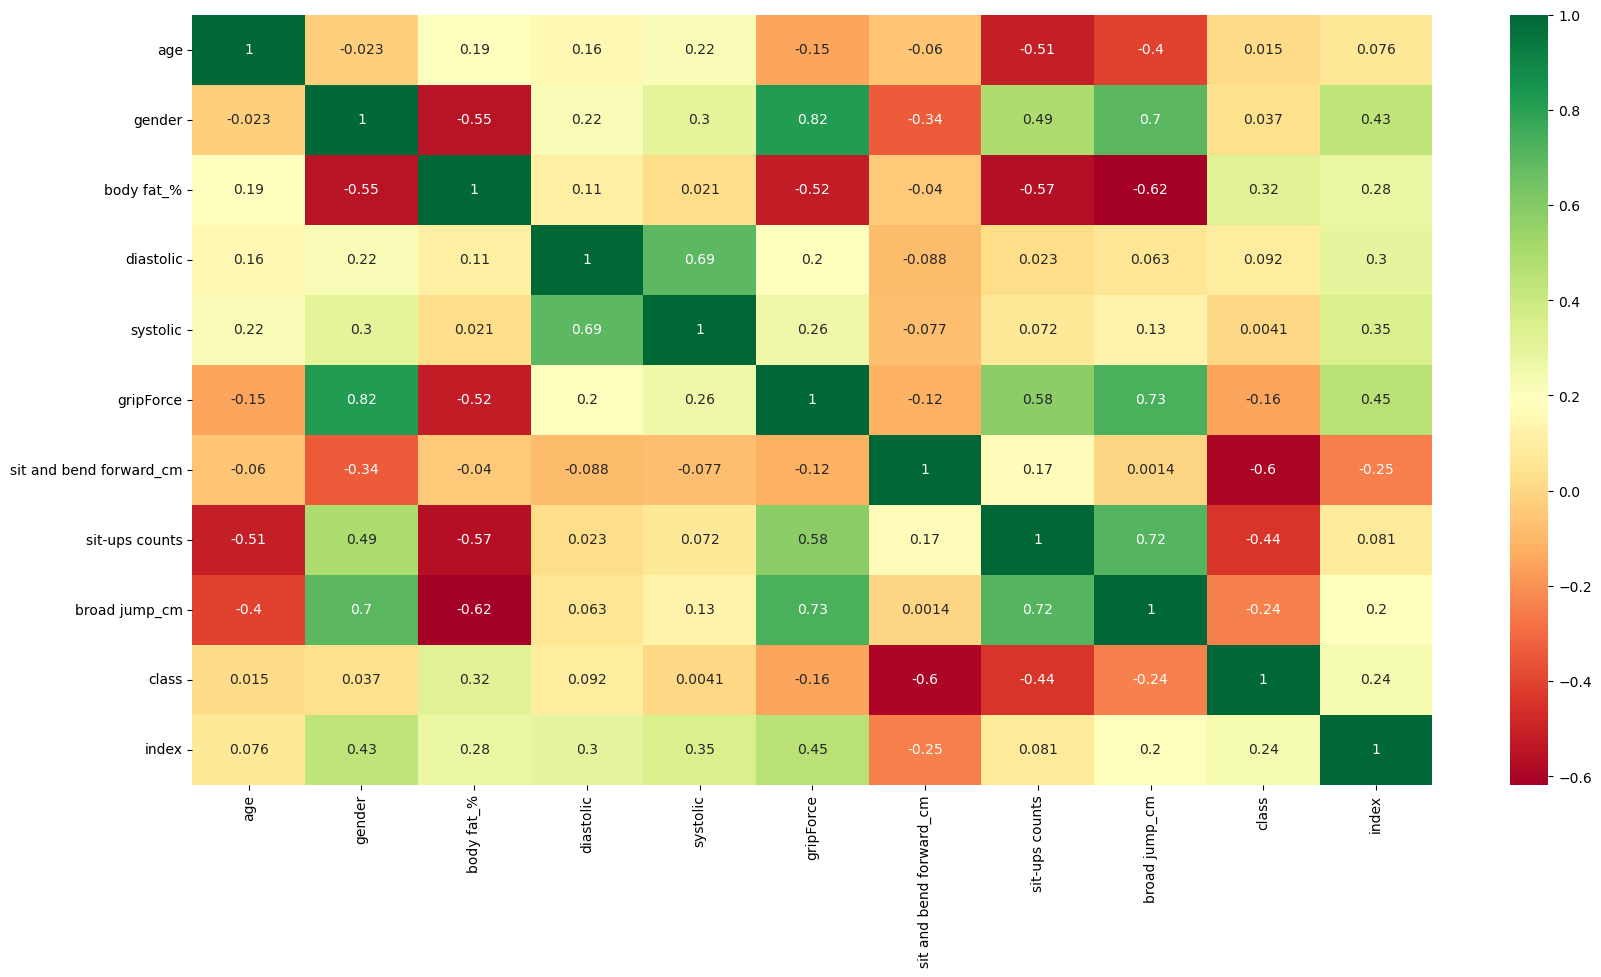

In [140]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

Заметно, что ранжирование людей по классам происходит справедливо с учетом их возраста (то есть для старых людей, возможно, нормативы меньше) -- иначе бы мы получили положительную корреляцию возраста и класса. Аналогично обстоят дела с показателями давления. Принимаем решение удалить данные признаки.

In [141]:
data.drop(['diastolic', 'systolic', 'age'], axis=1, inplace = True)

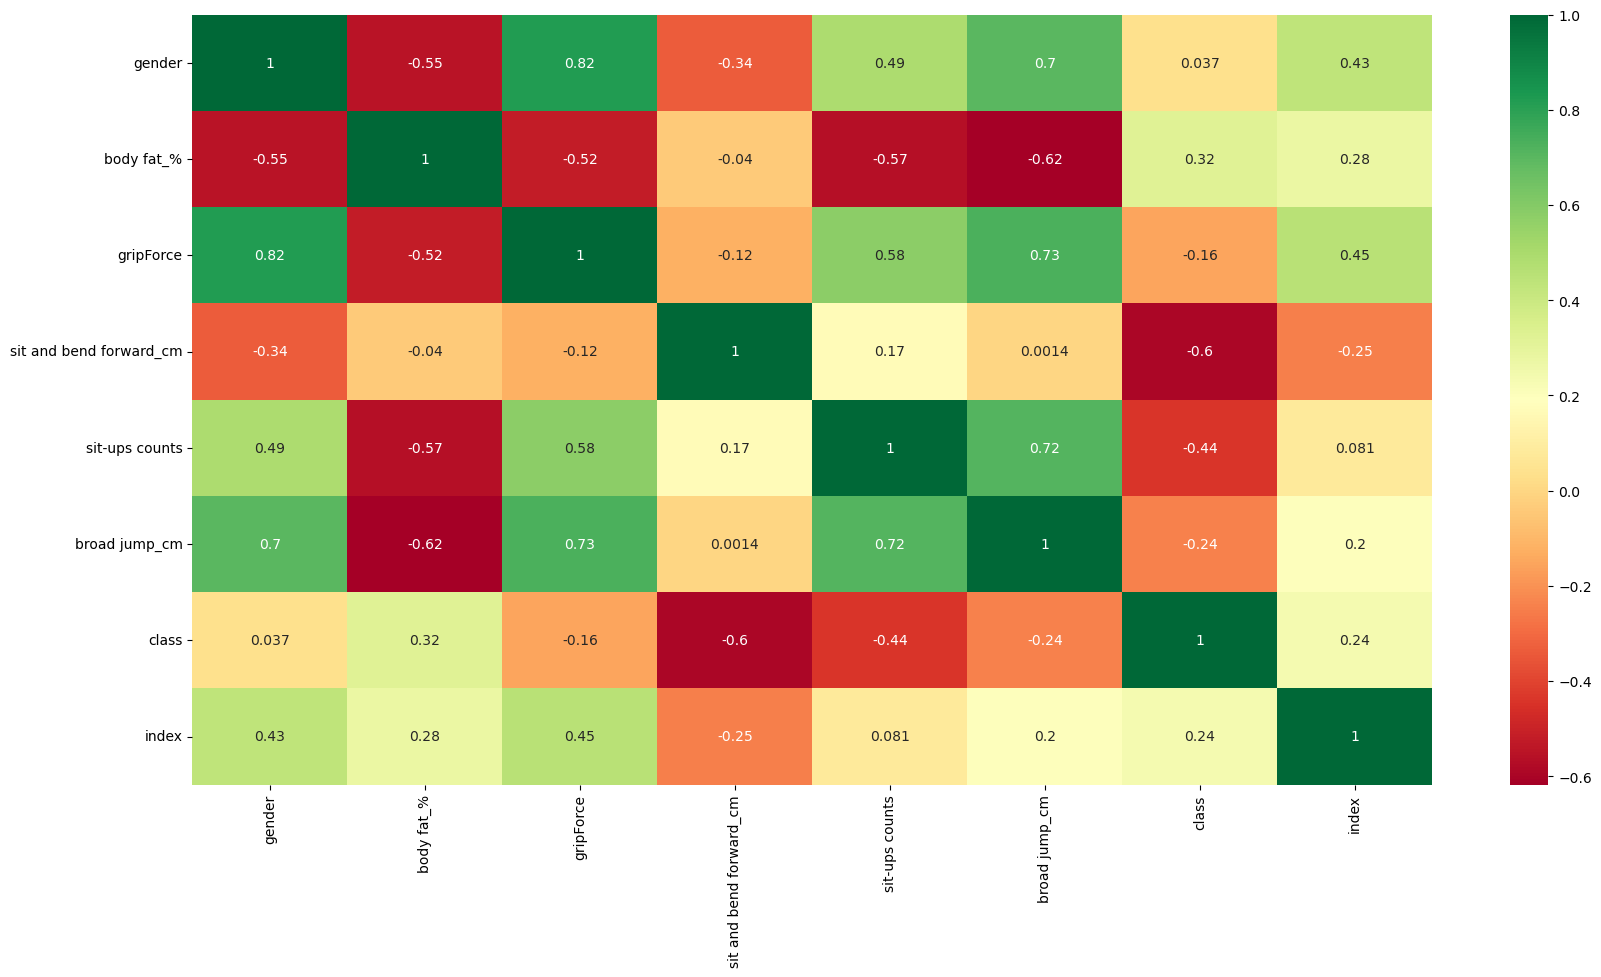

In [142]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [143]:
def print_results(results):
    table_data = { 'Name' : [], 'Time' : [], 'Train score' : [], 'Test score' : [] }
    for name, result in results.items():
        time, train, test = result
        table_data['Name'].append(name)
        table_data['Time'].append(time)
        table_data['Train score'].append(train)
        table_data['Test score'].append(test)
    df = pd.DataFrame(data=table_data)
    print(df)

In [144]:
def fit_and_predict(X_train, y_train, X_test, y_test):
    results = {}

    def _fit_and_predict(name, estimator, grid):

        model = GridSearchCV(estimator, param_grid=grid, scoring='roc_auc', cv=5)
        
        print('\tTraining OneVsOne...')

        one_vs_one = OneVsOneClassifier(model)
        one_vs_one_start = time.time()
        one_vs_one.fit(X_train, y_train.ravel())
        one_vs_one_time = time.time() - one_vs_one_start
        
        train_prediction = one_vs_one.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_prediction)

        test_prediction = one_vs_one.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_prediction)
        
        results[f'{name} (OneVsOne)'] = (one_vs_one_time, train_accuracy, test_accuracy)
        
        print('\tTraining OneVsRest...')

        one_vs_rest = OneVsRestClassifier(model)
        one_vs_rest_start = time.time()
        one_vs_rest.fit(X_train, y_train.ravel())
        one_vs_rest_time = time.time() - one_vs_rest_start
        
        train_prediction = one_vs_rest.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_prediction)

        test_prediction = one_vs_rest.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_prediction)
        
        results[f'{name} (OneVsRest)'] = (one_vs_rest_time, train_accuracy, test_accuracy)
        
        print('\tTraining OutputCode...')

        output_code = OutputCodeClassifier(model)
        output_code_start = time.time()
        output_code.fit(X_train, y_train.ravel())
        output_code_time = time.time() - output_code_start
        
        train_prediction = output_code.predict(X_train)
        train_accuracy = accuracy_score(y_train, train_prediction)

        test_prediction = output_code.predict(X_test)
        test_accuracy = accuracy_score(y_test, test_prediction)
        
        results[f'{name} (OutputCode)'] = (one_vs_rest_time, train_accuracy, test_accuracy)


    print('Training LogisticRegression...')
    _fit_and_predict(
        'LogisticRegression',
        LogisticRegression(),
        [{"max_iter": [250], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "penalty": ['none', 'l1', 'l2']}],
    )
    print('Training KNN...')
    _fit_and_predict(
        'KNN',
        KNeighborsClassifier(),
        [{"n_neighbors": list(range(1, 5)), "p": [1, 2]}],
    )
    print('Training SVM...')
    _fit_and_predict(
        'SVM',
        SVC(),
        [{'gamma': ['auto', 1, 0.1, 0.01], 'kernel': ['linear']}],
    )
    print('Training NaiveBayes...')
    _fit_and_predict(
        'NaiveBayes',
        GaussianNB(),
        [{'var_smoothing': np.logspace(0, -1, 10)}],
    )
    print('Training DecisionTree...')
    _fit_and_predict(
        'DecisionTree',
        DecisionTreeClassifier(),
        [{"max_depth": list(range(2, 30)), "min_samples_split": [5, 10, 25]}]
    )

    return results

In [145]:
def preprocess_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    return (X_train_scaled, X_test_scaled, y_train, y_test)

In [112]:
X = data.drop(columns=['class']).to_numpy()
y = data['class'].to_numpy()

(X_train, X_test, y_train, y_test) = preprocess_data(X, y)
results = fit_and_predict(X_train, y_train, X_test, y_test)
print_results(results)

Training LogisticRegression...
	Training OneVsOne...
	Training OneVsRest...
	Training OutputCode...
Training KNN...
	Training OneVsOne...
	Training OneVsRest...
	Training OutputCode...
Training SVM...
	Training OneVsOne...
	Training OneVsRest...
	Training OutputCode...
Training NaiveBayes...
	Training OneVsOne...
	Training OneVsRest...
	Training OutputCode...
Training DecisionTree...
	Training OneVsOne...
	Training OneVsRest...
	Training OutputCode...
                               Name      Time  Train score  Test score
0     LogisticRegression (OneVsOne)  1.154537     0.582857    0.580000
1    LogisticRegression (OneVsRest)  0.790066     0.538571    0.516667
2   LogisticRegression (OutputCode)  0.790066     0.524286    0.523333
3                    KNN (OneVsOne)  0.676330     0.661429    0.510000
4                   KNN (OneVsRest)  0.558902     0.714286    0.546667
5                  KNN (OutputCode)  0.558902     0.645714    0.520000
6                    SVM (OneVsOne)  0.527068  

## Выводы
- Приемлемые результаты показали LogisticRegression и DecisionTree
- DecisionTree обучается заметно дольше остальных моделей

 # 2. Multilabel classification

Датасет: https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019 (популярные песни в сервисе Spotify с характеристиками типа "танцевальности" (danceability) и т. д., предсказываем жанр песни)

In [120]:
data = pd.read_csv('songs.csv')

In [121]:
data.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


Добавим бинарные столбцы на каждый интересующий наш жанр. Для простоты оставим только pop, rock и hip hop. Признак explicit преобразуем в количественный.

In [122]:
data['pop'] = data['genre'].map(lambda g: 1 if 'pop' in g else 0)
data['rock'] = data['genre'].map(lambda g: 1 if 'rock' in g or 'metal' in g else 0)
data['hip hop'] = data['genre'].map(lambda g: 1 if 'hip hop' in g else 0)
data['explicit'] = data['explicit'].map(lambda e: 1 if e else 0)

In [123]:
data.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre,pop,rock,hip hop
0,Britney Spears,Oops!...I Did It Again,211160,0,2000,77,0.751,0.834,1,-5.444,...,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop,1,0,0
1,blink-182,All The Small Things,167066,0,1999,79,0.434,0.897,0,-4.918,...,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop",1,1,0
2,Faith Hill,Breathe,250546,0,1999,66,0.529,0.496,7,-9.007,...,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country",1,0,0
3,Bon Jovi,It's My Life,224493,0,2000,78,0.551,0.913,0,-4.063,...,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal",0,1,0
4,*NSYNC,Bye Bye Bye,200560,0,2000,65,0.614,0.928,8,-4.806,...,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop,1,0,0


Название песни, исполнителя, год, тональность в нашем случае мало что могут сказать о жанре, удалим эти признаки.

In [124]:
data.drop(['artist', 'song', 'year', 'key', 'genre'], axis=1, inplace = True)

In [125]:
data.head()

,duration_ms,explicit,popularity,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,pop,rock,hip hop
0,211160,0,77,0.751,0.834,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,1,0,0
1,167066,0,79,0.434,0.897,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,1,1,0
2,250546,0,66,0.529,0.496,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,1,0,0
3,224493,0,78,0.551,0.913,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,0,1,0
4,200560,0,65,0.614,0.928,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,1,0,0


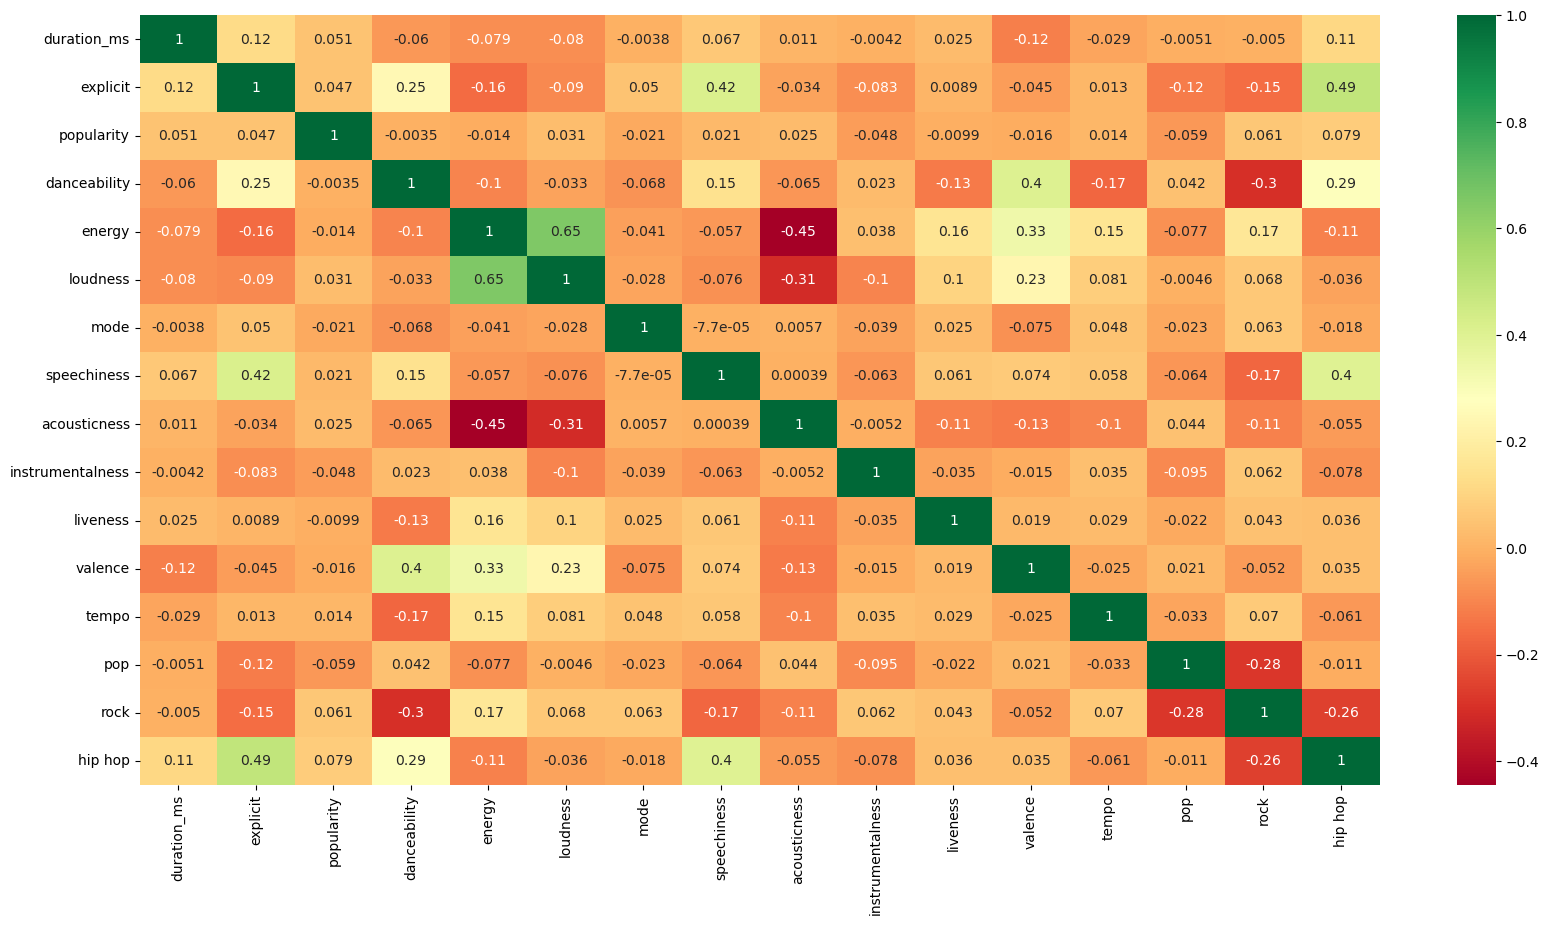

In [126]:
sns.heatmap(data.corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(20, 10)
plt.show()

In [127]:
def fit_and_predict(X_train, y_train, X_test, y_test):
    results = {}

    def _fit_and_predict(name, estimator, grid):

        model = GridSearchCV(estimator, param_grid=grid, scoring='roc_auc', cv=5)
        
        print('\tTraining MultiOutput...')

        multi_output = MultiOutputClassifier(model)
        multi_output_start = time.time()
        multi_output.fit(X_train, y_train)
        multi_output_time = time.time() - multi_output_start
        
        train_prediction = np.transpose([y_pred[:, 1] for y_pred in multi_output.predict_proba(X_train)])
        train_auc_roc = roc_auc_score(y_train, train_prediction)

        test_prediction = np.transpose([y_pred[:, 1] for y_pred in multi_output.predict_proba(X_test)])
        test_auc_roc = roc_auc_score(y_test, test_prediction)
        
        results[f'{name} (MultiOutput)'] = (multi_output_time, train_auc_roc, test_auc_roc)
        
        print('\tTraining ClassifierChain...')

        chain = ClassifierChain(model)
        chain_start = time.time()
        chain.fit(X_train, y_train)
        chain_time = time.time() - chain_start
        
        train_prediction = chain.predict_proba(X_train)        
        train_auc_roc = roc_auc_score(y_train, train_prediction)

        test_prediction = chain.predict_proba(X_test)
        test_auc_roc = roc_auc_score(y_test, test_prediction)
        
        results[f'{name} (ClassifierChain)'] = (chain_time, train_auc_roc, test_auc_roc)

    print('Training LogisticRegression...')
    _fit_and_predict(
        'LogisticRegression',
        LogisticRegression(),
        [{"max_iter": [250], "solver": ['newton-cg', 'lbfgs', 'liblinear'], "penalty": ['none', 'l1', 'l2']}],
    )
    print('Training KNN...')
    _fit_and_predict(
        'KNN',
        KNeighborsClassifier(),
        [{"n_neighbors": list(range(1, 5)), "p": [1, 2]}],
    )
    print('Training SVM...')
    _fit_and_predict(
        'SVM',
        SVC(probability=True),
        [{'gamma': ['auto', 1, 0.1, 0.01], 'kernel': ['linear']}],
    )
    print('Training NaiveBayes...')
    _fit_and_predict(
        'NaiveBayes',
        GaussianNB(),
        [{'var_smoothing': np.logspace(0, -1, 10)}],
    )
    print('Training DecisionTree...')
    _fit_and_predict(
        'DecisionTree',
        DecisionTreeClassifier(),
        [{"max_depth": list(range(2, 30)), "min_samples_split": [5, 10, 25]}]
     )

    return results

In [128]:
def preprocess_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)    
    return (X_train_scaled, X_test_scaled, y_train, y_test)

In [131]:
X = data.drop(columns=['pop', 'rock', 'hip hop']).to_numpy()
y = data[['pop', 'rock', 'hip hop']].to_numpy()

(X_train, X_test, y_train, y_test) = preprocess_data(X, y)

results = fit_and_predict(X_train, y_train, X_test, y_test)
print_results(results)

Training LogisticRegression...
	Training MultiOutput...
	Training ClassifierChain...
Training KNN...
	Training MultiOutput...
	Training ClassifierChain...
Training SVM...
	Training MultiOutput...
	Training ClassifierChain...
Training NaiveBayes...
	Training MultiOutput...
	Training ClassifierChain...
Training DecisionTree...
	Training MultiOutput...
	Training ClassifierChain...
                                   Name       Time  Train score  Test score
0      LogisticRegression (MultiOutput)   0.766790     0.775136    0.756498
1  LogisticRegression (ClassifierChain)   0.754127     0.774251    0.756904
2                     KNN (MultiOutput)   1.452266     0.907195    0.712834
3                 KNN (ClassifierChain)   1.474900     0.910409    0.700625
4                     SVM (MultiOutput)   8.478344     0.700903    0.701797
5                 SVM (ClassifierChain)  11.043505     0.708556    0.704340
6              NaiveBayes (MultiOutput)   0.316198     0.764070    0.744051
7          

## Выводы
- Лучше всего с задачей справилась логистическая регрессия, при этом обучение модели заняло достаточно мало времени
- В целом различные классификаторы на тестовой выборке показывают сравнимое качество, возможно, это связано с неравномерностью данных: жанр hip hop, как правило не пересекается с pop и rock